## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from pysparkling import *
import h2o
from pyspark import SparkConf, SparkContext

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,9 hours 14 mins
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_kalya_n6h9yb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.755 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Data Preparation

In [3]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Exploratory Data Analysis

In [4]:
data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [5]:
transfer=data[(data.isFraud==1) & (data.type=='TRANSFER')]
cash_out=data[(data.isFraud==1) & (data.type=='CASH_OUT')]
print('Fraudulent Transfers',len(transfer))
print('Fraudulent Cash Outs',len(cash_out))

Fraudulent Transfers 4097
Fraudulent Cash Outs 4116


In [6]:
print(data.loc[data.isFlaggedFraud==1].type.drop_duplicates())

2736446    TRANSFER
Name: type, dtype: object


In [7]:
print("Transfers where isFraud is set",len(transfer))
print("Tranfers where isFlaggedFraud set",len(data.loc[data.isFlaggedFraud==1]))                

Transfers where isFraud is set 4097
Tranfers where isFlaggedFraud set 16


In [8]:
notfraud=data.loc[data.isFraud==0]
print(transfer.loc[transfer.nameDest.isin(notfraud.loc[notfraud.type=='CASH_OUT'].nameOrig.drop_duplicates())])

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [9]:
print("fraudulent tranfer to C423543548 occurs at step 486 and cashout from this account occurs at step",notfraud.loc[(notfraud.type=='CASH_OUT') & (notfraud.nameOrig=="C423543548")].step.values)

fraudulent tranfer to C423543548 occurs at step 486 and cashout from this account occurs at step [185]


In [10]:
X=data.loc[(data.type=='TRANSFER') | (data.type=='CASH_OUT')]
X=X.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
Y=X['isFraud']

In [11]:
X.loc[X.type=='TRANSFER','type']=0
X.loc[X.type=='CASH_OUT','type']=1
X.type=X.type.astype(int)
X.head(10)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.00,0.0,0.0,0.00,1
3,1,1,181.00,181.00,0.0,21182.0,0.00,1
15,1,1,229133.94,15325.00,0.0,5083.0,51513.44,0
19,1,0,215310.30,705.00,0.0,22425.0,0.00,0
24,1,0,311685.89,10835.00,0.0,6267.0,2719172.89,0
42,1,1,110414.71,26845.41,0.0,288800.0,2415.16,0
47,1,1,56953.90,1942.02,0.0,70253.0,64106.18,0
48,1,1,5346.89,0.00,0.0,652637.0,6453430.91,0
51,1,1,23261.30,20411.53,0.0,25742.0,0.00,0
58,1,0,62610.80,79114.00,16503.2,517.0,8383.29,0


In [12]:
Xfraud=X.loc[Y==1]
Xnonfraud=X.loc[Y==0]
print("The fraction of fraudulent transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:\n",len(Xfraud.loc[(Xfraud.oldbalanceDest==0) & (Xfraud.newbalanceDest==0)])/len(Xfraud))

The fraction of fraudulent transactions with oldbalanceDest= newbalanceDest= 0 although the transacted amount is non-zero is:
 0.49628637525873615


In [13]:
print("The fraction of fraudulent transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:\n",len(Xfraud.loc[(Xfraud.oldbalanceOrg==0) & (Xfraud.newbalanceOrig==0)])/len(Xfraud))

The fraction of fraudulent transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:
 0.00499208571776452


In [14]:
print("The fraction of genuine transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:\n",len(Xnonfraud.loc[(Xnonfraud.oldbalanceOrg==0) & (Xnonfraud.newbalanceOrig==0)])/len(Xnonfraud))

The fraction of genuine transactions with oldbalanceOrg= newbalanceOrig= 0 although the transacted amount is non-zero is:
 0.4737321319703598


In [15]:
X.loc[(X.oldbalanceDest==0) & (X.newbalanceDest==0) & (X.amount!=0),['oldbalanceDest','newbalanceDest']]=-1
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.0,0.0,-1.0,-1.00,1
3,1,1,181.00,181.0,0.0,21182.0,0.00,1
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [16]:
data=X
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,181.00,181.00,0.0,-1.00,-1.00,1
3,1,1,181.00,181.00,0.0,21182.00,0.00,1
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,0,215310.30,705.00,0.0,22425.00,0.00,0
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,0,6311409.28,6311409.28,0.0,-1.00,-1.00,1
6362617,743,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,0,850002.52,850002.52,0.0,-1.00,-1.00,1


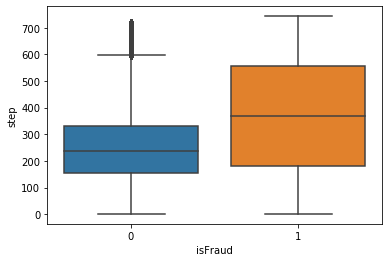

In [17]:
sns.boxplot(x='isFraud',y='step',data=X)

In [18]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


In [19]:
Y

2          1
3          1
15         0
19         0
24         0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 2770409, dtype: int64

## Data Preparation

In [20]:
X_train,X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
hf = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
features = ['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
target = "isFraud"
train,test,valid = hf.split_frame(ratios=[.7,.15])
train

step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
1,0,215310,705,0,22425,0,0
1,0,311686,10835,0,6267,2.71917e+06,0
1,1,110415,26845.4,0,288800,2415.16,0
1,1,56953.9,1942.02,0,70253,64106.2,0
1,1,5346.89,0,0,652637,6.45343e+06,0
1,1,23261.3,20411.5,0,25742,0,0
1,1,82940.3,3017.87,0,132372,49864.4,0
1,1,47458.9,209535,162076,52120,0,0
1,1,94253.3,25203,0,99773,965870,0
1,0,42712.4,10363.4,0,57901.7,24044.2,0


## H2O

In [23]:
#We only provide the required parameters, everything else is default
gbm = H2OGradientBoostingEstimator()
gbm.train(x=features, y=target, training_frame=train)

## Show a detailed model summary
print(gbm)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1596611725901_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,19289.0,5.0,5.0,5.0,19.0,31.0,25.98




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.000938222607821719
RMSE: 0.03063041964814911
MAE: 0.0024477328769105192
RMSLE: 0.021036714149482594
Mean Residual Deviance: 0.000938222607821719

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-08-05 17:31:05,0.002 sec,0.0,0.054257,0.005888,0.002944
1,,2020-08-05 17:31:06,0.763 sec,1.0,0.052255,0.005663,0.002731
2,,2020-08-05 17:31:06,1.263 sec,2.0,0.050369,0.005441,0.002537
3,,2020-08-05 17:31:07,1.789 sec,3.0,0.048907,0.005254,0.002392
4,,2020-08-05 17:31:07,2.289 sec,4.0,0.047529,0.005071,0.002259
5,,2020-08-05 17:31:08,2.695 sec,5.0,0.046412,0.004910,0.002154
6,,2020-08-05 17:31:08,2.983 sec,6.0,0.045533,0.004771,0.002073
7,,2020-08-05 17:31:08,3.282 sec,7.0,0.044826,0.004650,0.002009
8,,2020-08-05 17:31:09,3.583 sec,8.0,0.044206,0.004535,0.001954
9,,2020-08-05 17:31:13,7.622 sec,20.0,0.037952,0.003463,0.001440



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,oldbalanceOrg,5533.034180,1.000000,0.270281
1,amount,4243.074219,0.766862,0.207268
2,type,4193.850586,0.757966,0.204864
3,newbalanceOrig,2678.223145,0.484042,0.130828
4,step,2184.068359,0.394732,0.106689
5,newbalanceDest,1328.479492,0.240100,0.064894
6,oldbalanceDest,310.668091,0.056148,0.015176


In [24]:
## Get the AUC on the validation set
perf = gbm.model_performance(valid)
perf.r2()

0.6620417567642723

In [25]:
perf.auc


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.0009856638986972105
RMSE: 0.03139528465705018
MAE: 0.002497463366892626
RMSLE: 0.021603579141495174
Mean Residual Deviance: 0.0009856638986972105


<bound method MetricsBase.auc of >

## Support Vector Machine (SVM)

In [26]:
# Build and train the model:
svm_model = SVC(kernel='linear', gamma=10)

In [ ]:
svm_model.fit(X_train, y_train)

In [ ]:
ypred= svm_model.predict(X_test)

In [ ]:
accuracy_score(y_test,ypred)

In [ ]:
f1_score(y_test,ypred)

## Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)

In [ ]:
decision_tree.fit(X_train, y_train)

In [ ]:
ypred= decision_tree.predict(X_test)

In [ ]:
accuracy_score(y_test,ypred)

In [ ]:
f1_score(y_test,ypred)

## Naive Bayes

In [ ]:
clf = GaussianNB()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
ypred= clf.predict(X_test)

In [ ]:
accuracy_score(y_test,ypred)

In [ ]:
f1_score(y_test,ypred)